In [ ]:
import numpy as np
from scipy.interpolate import griddata
from scipy.spatial import cKDTree
import laspy
from scipy import ndimage
from tqdm import tqdm
import os

In [ ]:
def print_las_info(las_path):
    """
    Выводит основную информацию о LAS/LAZ файле:
    количество точек, границы (X, Y, Z), размер области и примерную плотность.
    x, y - 
    z - высота
    """
    with laspy.open(las_path) as f:
        header = f.header
        num_points = header.point_count
        min_x, max_x = header.mins[0], header.maxs[0]
        min_y, max_y = header.mins[1], header.maxs[1]
        min_z, max_z = header.mins[2], header.maxs[2]

        width = max_x - min_x
        lenght = max_y - min_y
        area = width * lenght if width > 0 and lenght > 0 else np.nan
        density = num_points / area if area and not np.isnan(area) else np.nan

        print(f"\nФайл: {os.path.basename(las_path)}")
        print(f"Формат версии: {header.version}")
        print(f"Количество точек: {num_points:,}")
        print(f"Диапазон координат (X, Y, Z):")
        print(f"  X: {min_x:.2f} - {max_x:.2f}  (ширина {width:.2f} м)")
        print(f"  Y: {min_y:.2f} - {max_y:.2f}  (размах {lenght:.2f} м)")
        print(f"  Z: {min_z:.2f} - {max_z:.2f}  (высота {max_z - min_z:.2f} м)")
        print(f"Площадь покрытия: {area/1e6:.2f} км²")

        print(f"Средняя плотность: {density:.2f} точек/м²\n")

        # Первые несколько точек
        print("Пример точек:")
        for points in f.chunk_iterator(3):
            for i in range(3):
                print(f"x: {points.x[i]:.2f} y: {points.y[i]:.2f} z: {points.z[i]:.2f}")
            break

In [ ]:
def save_las_points(
    original_las: laspy.LasData,
    points: np.ndarray,
    output_path: str,
    copy_attributes: bool = True
):
    """
    Сохраняет LAS-файл из массива точек, копируя метаданные и при желании атрибуты.

    Args:
        original_las (laspy.LasData): исходный LAS-файл (для копирования header и метаданных)
        points (np.ndarray): Nx3 массив координат (x, y, z)
        output_path (str): путь для сохранения
        copy_attributes (bool): копировать ли intensity, classification и т.д.
    """
    
    # создаём новый заголовок на основе оригинала
    header = laspy.LasHeader(
        point_format=original_las.header.point_format,
        version=original_las.header.version
    )
    header.scales = original_las.header.scales
    header.offsets = original_las.header.offsets

    # создаём новый LAS-объект
    new_las = laspy.LasData(header)

    # записываем координаты
    new_las.x = points[:, 0]
    new_las.y = points[:, 1]
    new_las.z = points[:, 2]

    # при необходимости копируем остальные поля
    if copy_attributes:
        attrs = [
            'intensity', 'return_number', 'number_of_returns',
            'classification', 'user_data', 'gps_time',
            'red', 'green', 'blue'
        ]
        for attr in attrs:
            if hasattr(original_las, attr):
                data = getattr(original_las, attr)
                if len(data) == len(original_las.points):
                    new_las[attr] = data[:len(points)]  # если точек меньше, копируем соответствующее количество

    # сохраняем
    new_las.write(output_path)
    print(f"Saved {len(points):,} points to {output_path}")

In [ ]:
def compute_local_density(points, radius, chunk_size=100, leafsize=16):
    """
    Вычисляет локальную плотность для каждого point: rho = count / volume.
    Работает чанками, использует cKDTree.query_ball_point.

    Args:
        points (np.ndarray): Nx3 массив (x,y,z)
        radius (float): радиус поиска в метрах
        chunk_size (int): размер чанка по точкам для пониженного потребления RAM
        leafsize (int): параметр дереву (ускоряет запросы)

    Returns:
        densities (np.ndarray): N-array плотностей (точек/м^3)
        counts (np.ndarray): N-array количества соседей (включая саму точку)
    """
    N = points.shape[0]
    tree = cKDTree(points, leafsize=leafsize)
    counts = np.empty(N, dtype=np.int32)

    vol = (4.0/3.0) * np.pi * (radius**3)
    # Обход по чанкам, чтобы не получить гигантские списки
    for start in range(0, N, chunk_size):
        end = min(N, start + chunk_size)
        # query_ball_point возвращает список списков индексов
        neighbors = tree.query_ball_point(points[start:end, :], r=radius)
        # длины списков = количество соседей
        counts[start:end] = np.fromiter((len(lst) for lst in neighbors), dtype=np.int32)

    densities = counts.astype(float) / vol
    return densities, counts


def compute_relative_density(points, r_small, r_large, chunk_size=100, eps=1e-8):
    """
    Для каждой точки вычисляет относительную плотность
      D_rel = rho_small / (rho_large + eps)

    Возвращает rho_small, rho_large, D_rel, а также raw counts (n_small, n_large).
    """
    # Плотность в меньшей окрестности
    rho_small, n_small = compute_local_density(points, r_small, chunk_size=chunk_size)
    # Плотность в большей окрестности
    rho_large, n_large = compute_local_density(points, r_large, chunk_size=chunk_size)

    # Относительная плотность
    return rho_small / (rho_large + eps)

In [3]:
las_path = "non_ground.las"
chunk_size = 1000
candidates = []

with laspy.open(las_path) as f:
    # Потоково читаем точки из исходного файла
    for chunk_idx, chunk_points in enumerate(f.chunk_iterator(chunk_size)):
        points = np.vstack((chunk_points.x, chunk_points.y, chunk_points.z)).transpose()
        D_rel = compute_relative_density(points, 0.3, 5, chunk_size//10)
        mask = select_density_candidates(points, D_rel)
        candidates.append(points[mask])

        print(f"   Обработано {chunk_idx+1} чанков ({(chunk_idx+1)*chunk_size:,} точек)")

   Обработано 1 чанков (1,000 точек)
   Обработано 2 чанков (2,000 точек)
   Обработано 3 чанков (3,000 точек)
   Обработано 4 чанков (4,000 точек)
   Обработано 5 чанков (5,000 точек)
   Обработано 6 чанков (6,000 точек)
   Обработано 7 чанков (7,000 точек)
   Обработано 8 чанков (8,000 точек)
   Обработано 9 чанков (9,000 точек)
   Обработано 10 чанков (10,000 точек)
   Обработано 11 чанков (11,000 точек)
   Обработано 12 чанков (12,000 точек)
   Обработано 13 чанков (13,000 точек)
   Обработано 14 чанков (14,000 точек)
   Обработано 15 чанков (15,000 точек)
   Обработано 16 чанков (16,000 точек)
   Обработано 17 чанков (17,000 точек)
   Обработано 18 чанков (18,000 точек)
   Обработано 19 чанков (19,000 точек)
   Обработано 20 чанков (20,000 точек)
   Обработано 21 чанков (21,000 точек)
   Обработано 22 чанков (22,000 точек)
   Обработано 23 чанков (23,000 точек)
   Обработано 24 чанков (24,000 точек)
   Обработано 25 чанков (25,000 точек)
   Обработано 26 чанков (26,000 точек)
   О

In [69]:
las_path = "non_ground.las"
chunk_size = 1000
density = np.array([])

with laspy.open(las_path) as f:
    total_points = f.header.point_count
    total_chunks = total_points // chunk_size + (1 if total_points % chunk_size else 0)

    print(f"В файле {total_points} точек\nБудет обработано {total_chunks} чанков")
    # Используем tqdm для прогресс-бара
    for chunk_points in tqdm(f.chunk_iterator(chunk_size), total=total_chunks, desc="  Обработка чанков"):
        points = np.vstack((chunk_points.x, chunk_points.y, chunk_points.z)).transpose()
        D_rel = compute_relative_density(points, 0.3, 5, chunk_size//10)
        # mask = select_density_candidates(points, D_rel)
        # candidates.append(points[mask])

        density = np.concatenate((density, D_rel))


В файле 1182178 точек
Будет обработано 1183 чанков


  Обработка чанков: 100%|██████████| 1183/1183 [02:04<00:00,  9.50it/s]


(1182178,)
4.63 - 4629.63
1503.5280085410411


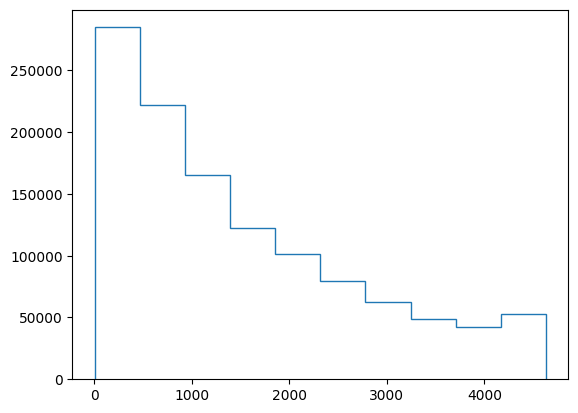

In [ ]:
from matplotlib import pyplot as plt

print(density.shape)
print(f"{density.min():.2f} - {density.max():.2f}")
print(density.mean())
counts, bins = np.histogram(density)
plt.stairs(counts, bins)

In [ ]:
density_threshold = 700

mask = density > density_threshold

las = laspy.read("non_ground.las")
points = np.vstack((las.x, las.y, las.z)).transpose()

print(f"Tree points: {np.sum(mask)}")
print(f"Non tree points: {np.sum(~mask)}")

ground_points     = points[mask]
non_ground_points = points[~mask]


save_las_points(las, ground_points, "con_v3.las")
save_las_points(las, non_ground_points, "non_con.las")

Tree points: 775015
Non tree points: 407163
Saved 775,015 points to con_v3.las
Saved 407,163 points to non_con.las


: 

In [4]:
candidates = np.vstack(candidates)
print(candidates.shape)

(777823, 3)


In [32]:
las = laspy.read(las_path)

save_las_points(las, candidates, "can.las")

Saved 777,823 points to can.las


In [64]:
print_las_info("can.las")


Файл: can.las
Формат версии: 1.2
Количество точек: 777,823
Диапазон координат (X, Y, Z):
  X: -0.15 - 39.85  (ширина 40.00 м)
  Y: -61.56 - -27.03  (размах 34.53 м)
  Z: 0.50 - 12.00  (высота 11.50 м)
Площадь покрытия: 0.00 км²
Средняя плотность: 563.17 точек/м²

Пример точек:
x: -0.07 y: -60.33 z: 8.00
x: -0.10 y: -60.33 z: 8.02
x: -0.07 y: -60.32 z: 8.02


### Фильтрация кандидатов

In [ ]:
tree = cKDTree(candidates, leafsize=16)
neighbors = tree.query_ball_point(candidates, r=1)
counts = np.fromiter((len(lst) for lst in neighbors), dtype=np.int32)

In [6]:
N = candidates.shape[0]
tree = cKDTree(candidates, leafsize=16)
counts = np.empty(N, dtype=np.int32)

# Обход по чанкам, чтобы не получить гигантские списки
for start in range(0, N, chunk_size):
    end = min(N, start + chunk_size)
    # query_ball_point возвращает список списков индексов
    neighbors = tree.query_ball_point(candidates[start:end, :], r=0.1)
    # длины списков = количество соседей
    counts[start:end] = np.fromiter((len(lst) for lst in neighbors), dtype=np.int32)

In [ ]:
# Порог: если в окрестности мало соседей, то - шум
print(counts)
print(f"{min(counts)} - {max(counts)}")
print(np.mean(counts))
print(np.average(counts))
mask = counts > 50

candidates_v2 = candidates[mask]
print(candidates_v2.shape)

[ 7  9  9 ... 11  8  8]
1 - 555
92.27824710763245
92.27824710763245
(438773, 3)


In [30]:
print(sum(counts))

las = laspy.read(las_path)

save_las_points(las, candidates_v2, "can_v2.las")

71776143
Saved 438,773 points to can_v2.las
